## 0. Getting Setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1
torchvision version: 0.15.2


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

c:\Users\adars\miniconda3\envs\midlar\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create datasets and dataloaders

### 2.1 Prepare transforms for images

In [6]:
from torchvision import transforms

IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually Created Transforms: {manual_transforms}")

Manually Created Transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


### 2.2 Turn images into dataloaders

In [7]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x18f9c0b7b90>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [8]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

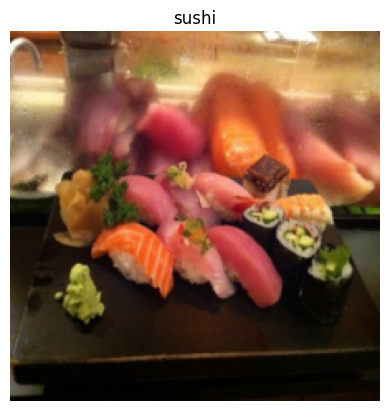

In [9]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be imtimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention).
* **Blocks** - A collection of layers.
* **Model (or architecture)** - A collection of blocks.

### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.
* Text descriptions (especially section 3.1)



### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>

* Embedding = learnable representation (start with random numbers and improve over time) 



### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

#### Section 3.1 describes the various equations:

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```



---

**Equations 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2 
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3 
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block 
```
---


**Equation 4:**
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_{L}^{0}$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time 

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block)) 
```

### Table 1 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
* ViT-B/16 = ViT-Base with image patch size 16x16 
* Layers - the number of transformer encoder layers 
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention 


## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output shape: ???

### 4.1 Calculate input and output shapes by hand

> **Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)


In [10]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width)/ patch_size ** 2)
number_of_patches

196

In [11]:
# Input_shape
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


### 4.2 Patching the Images

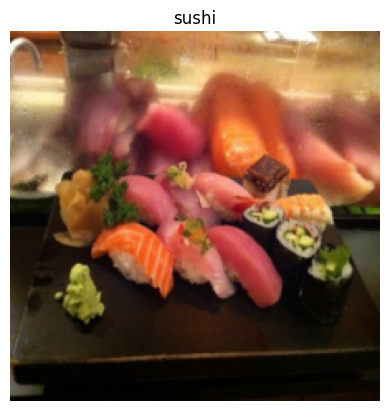

In [12]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

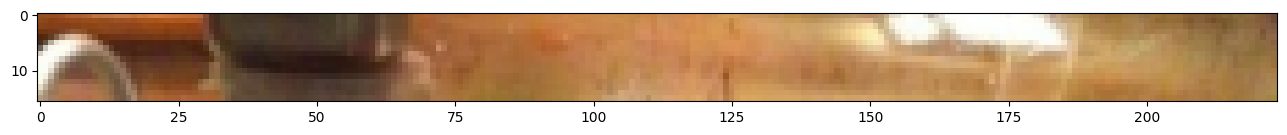

In [13]:
permuted_image  = image.permute(1, 2, 0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(permuted_image[:patch_size, :, :]);

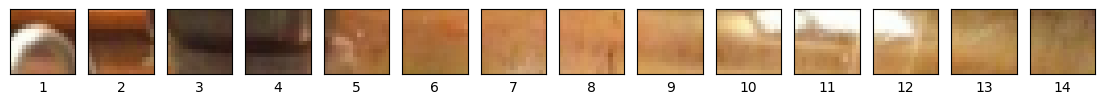

In [14]:
image_size = 224
patch_size = 16

num_patches = image_size / patch_size

assert image_size % patch_size == 0, "Image size must be divisible by patch size"

fig, ax = plt.subplots(nrows=1,
                        ncols=image_size // patch_size,
                        figsize=(num_patches, num_patches))


for i , patch in enumerate(range(0, image_size, patch_size)):
    ax[i].imshow(permuted_image[:patch_size, patch:patch+patch_size, :])
    ax[i].set_xlabel(i+1) # set the label
    ax[i].set_xticks([])
    ax[i].set_yticks([])

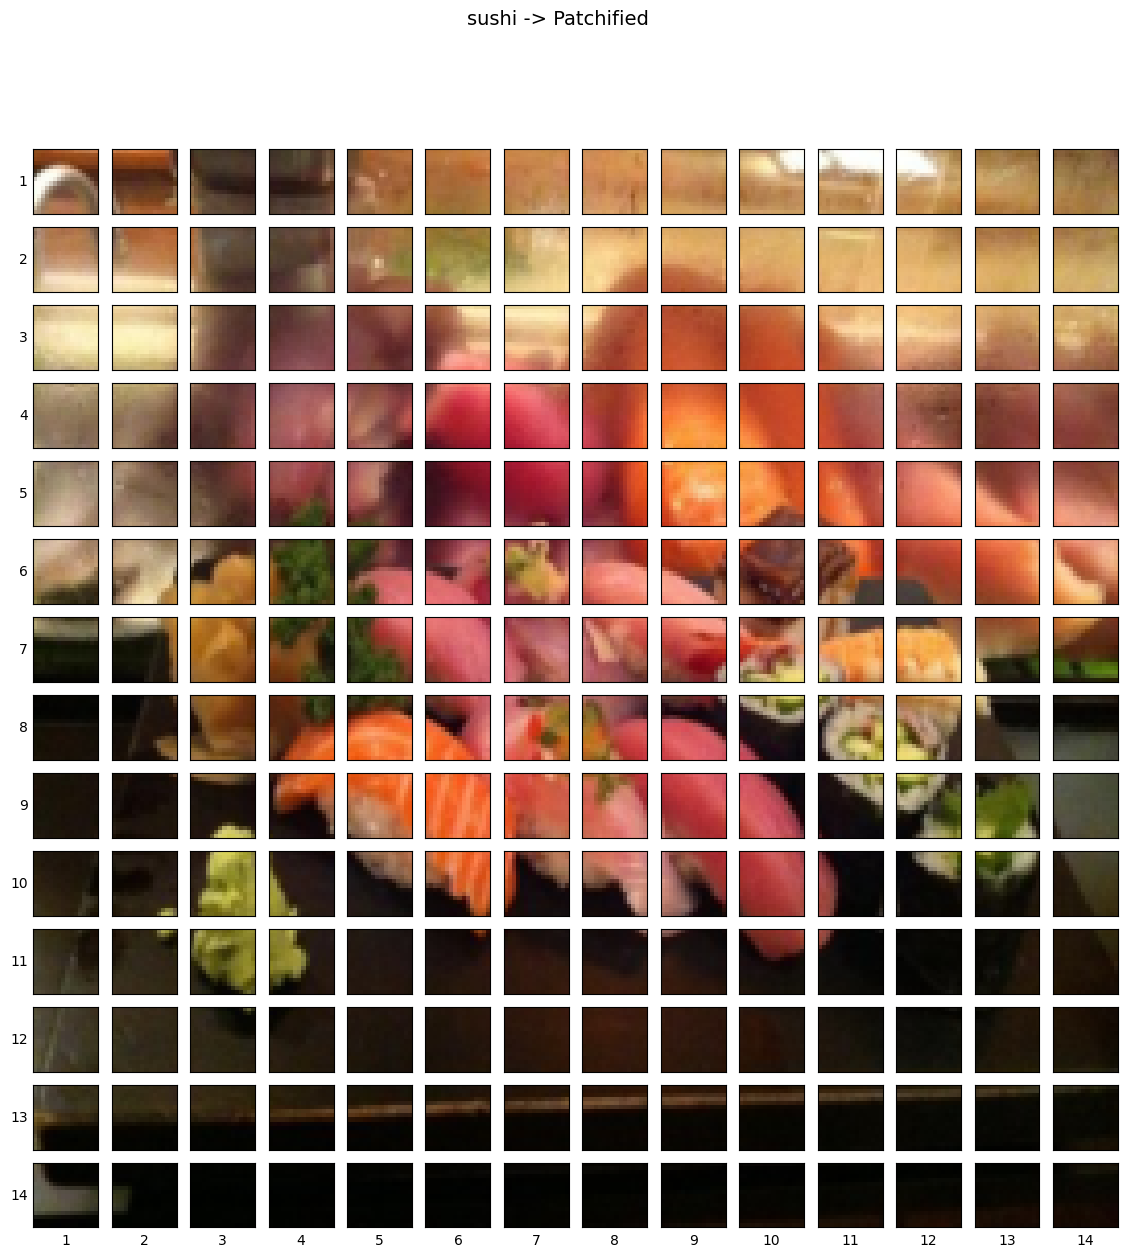

In [15]:
image_size = 224
patch_size = 16

num_patches = image_size / patch_size

assert image_size % patch_size == 0, "Image size must be divisible by patch size"

fig, ax = plt.subplots(nrows=image_size // patch_size,
                        ncols=image_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, image_size, patch_size)):
    for j , patch_width in enumerate(range(0, image_size, patch_size)):
        ax[i][j].imshow(permuted_image[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])
        ax[i][j].set_ylabel(i+1,
                            rotation="horizontal",
                            horizontalalignment="right",
                            verticalalignment="center") 
        ax[i][j].set_xticks([])
        ax[i][j].set_xlabel(j+1) 
        ax[i][j].set_yticks([])
        ax[i][j].label_outer()
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14);

### 4.3 Patch and turn images into embeddings

In [16]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                    out_channels=768,
                    kernel_size=patch_size,
                    stride=patch_size,
                    padding=0)

In [17]:
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

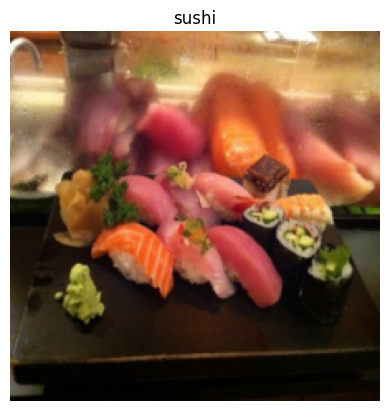

In [18]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [19]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


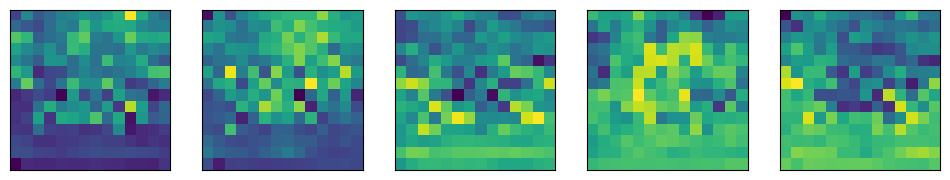

In [20]:
import random
random_indexes = random.sample(range(0, 758), k=5)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    img_ftr_map = image_out_of_conv[:, idx, :, :]
    ax[i].imshow(img_ftr_map.squeeze().detach().numpy())
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [21]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.4298, 0.2776, 0.1975, 0.2770, 0.3201, 0.4442, 0.4714, 0.4870,
           0.5150, 0.6553, 0.6727, 0.6323, 0.3895, 0.3020],
          [0.3314, 0.2722, 0.2890, 0.2622, 0.3183, 0.3362, 0.5546, 0.5256,
           0.5747, 0.5537, 0.5316, 0.4685, 0.3874, 0.3724],
          [0.6240, 0.5914, 0.2494, 0.2404, 0.2718, 0.5349, 0.6664, 0.4506,
           0.3437, 0.4289, 0.6700, 0.6060, 0.5356, 0.5263],
          [0.4372, 0.4261, 0.2734, 0.3615, 0.3030, 0.4669, 0.4998, 0.3787,
           0.4248, 0.3718, 0.4184, 0.3313, 0.3479, 0.3497],
          [0.3728, 0.2893, 0.1859, 0.3606, 0.3299, 0.1726, 0.3020, 0.3731,
           0.5599, 0.4751, 0.3746, 0.4989, 0.2451, 0.2271],
          [0.4981, 0.5346, 0.1449, 0.2283, 0.1424, 0.2893, 0.3071, 0.2583,
           0.3529, 0.4012, 0.3363, 0.3722, 0.5559, 0.5295],
          [0.3305, 0.4572, 0.3993, 0.1248, 0.3631, 0.5040, 0.4049, 0.4162,
           0.5088, 0.3800, 0.2824, 0.3407, 0.3164, 0.3717],
          [0.0302, 0.0619, 0.2861, 0.2165, 0.1967, 0.27

### 4.4 Flatten the embeddings to pass into ViT

In [22]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [23]:
from torch import nn
flatten = nn.Flatten(start_dim=2, end_dim=-1)

In [24]:
flattened_feature_maps = flatten(image_out_of_conv)

In [25]:
flattened_feature_maps.shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


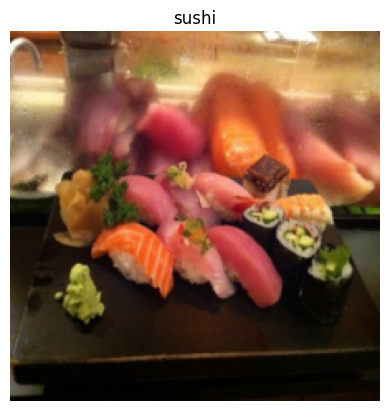

In [26]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [27]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


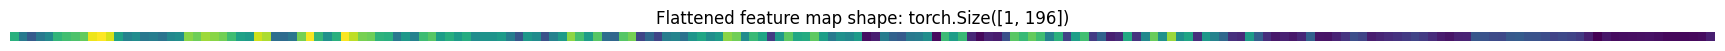

In [28]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Creating the patch embedding into a single pytorch module

In [29]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int = 768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=-1)
    
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [30]:
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


### 4.6 Creating the class token embedding

In [31]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [32]:
patch_embedding_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                 dim=1)
print(patch_embedding_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedding_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0368, -0.2384,  0.4884,  ...,  0.0340,  0.2616,  0.3756],
         [-0.0508, -0.0975,  0.4475,  ...,  0.0563, -0.0613,  0.2101],
         ...,
         [ 0.0339, -0.0469,  0.0457,  ...,  0.0108, -0.0225,  0.0754],
         [ 0.0298, -0.0432,  0.0485,  ...,  0.0144, -0.0062,  0.0627],
         [ 0.0344, -0.0326,  0.0708,  ...,  0.0063, -0.0221,  0.0771]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.7 Creating the position embedding

In [33]:
number_of_patches = int((height * width) / patch_size**2)

embedding_dimension = patch_embedding_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [34]:
patch_and_position_embedding = patch_embedding_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9632, 0.7616, 1.4884,  ..., 1.0340, 1.2616, 1.3756],
         [0.9492, 0.9025, 1.4475,  ..., 1.0563, 0.9387, 1.2101],
         ...,
         [1.0339, 0.9531, 1.0457,  ..., 1.0108, 0.9775, 1.0754],
         [1.0298, 0.9568, 1.0485,  ..., 1.0144, 0.9938, 1.0627],
         [1.0344, 0.9674, 1.0708,  ..., 1.0063, 0.9779, 1.0771]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.8 Putting it all together

In [35]:
patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width  = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")


number_of_patches = int((height * width) / patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multi-head Self Attention Layer (MSA block)

In [39]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads: int = 12,
                 attn_droput: float =0.0):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_droput,
                                                    batch_first=True)
    
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                          key=x,
                                          value=x,
                                          need_weights=False)
        return attn_output

In [40]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_droput=0)
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])
